In [75]:
import random
import pandas as pd
from sklearn import feature_extraction
from sklearn.cluster import KMeans 
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

In [76]:
#Load the corpus
genre_name = "'American poetry'"

in_filepath = f"df_cleaned/{genre_name}/"
out_filepath = f'df_cleaned/{genre_name}/'

delimiter = "line"

filename = f"{delimiter}_merged_df.csv"

In [77]:
df = pd.read_csv(in_filepath+filename, index_col = 0)
df

,Poem Title,line
0,I,in the acadian land on the shores of the basin...
1,I,lay in the fruitful valley vast meadows stret...
2,I,giving the village its name and pasture to flo...
3,I,dikes that the hands of the farmers had raised...
4,I,shut out the turbulent tides but at stated sea...
...,...,...
1181,V.,only along the shore of the mournful and misty...
1182,V.,wandered back to their native land to die in i...
1183,V.,in the fishermans cot the wheel and the loom a...
1184,V.,maidens still wear their norman caps and their...


In [78]:
#Use association measures to find multi-word expressions in Gensim
phrase_model = Phrases([doc.split() for doc in df.loc[:,delimiter].values], 
                        min_count = 2, 
                        threshold = 0.7, 
                        connector_words = ENGLISH_CONNECTOR_WORDS, scoring = "npmi"
                        )

print(phrase_model.export_phrases().keys())
print("ABOVE: Learned phrases")

dict_keys(['basin_of_minas', 'matrons_and_maidens', 'within_doors', 'angelus_sounded', 'olden_time', 'father_felician', 'basil_the_blacksmith', 'nest_of_the_swallow', 'no_longer', 'acadian_peasants', 'lowing_of_cattle', 'flickering_light', 'old_mans', 'art_thou', 'seat_by_the_fireside', 'thou_hast', 'forebodings_of_ill', 'gaspereaus_mouth', 'port_royal', 'been_taken', 'made_answer', 'round_about', 'rené_leblanc', 'papers_and_inkhorn', 'old_french', 'french_fort', 'yet_am', 'i_know', 'better_than', 'statue_of_justice', 'laws_of_the_land', 'scales_of_the_balance', 'necklace_of_pearls', 'fain_would', 'tankard_of_ale', 'meanwhile_apart', 'silence_reigned', 'neighboring_hamlets', 'michael_the_fiddler', 'steps_of_the_altar', 'madly_rushed', 'our_homes', 'ascended_the_steps', 'gazing_upon', 'o_father', 'father_forgive', 'let_us', 'thus_did', 'risen_and_set', 'mournful_procession', 'household_goods', 'once_more', 'good_cheer', 'suddenly_paused', 'lifeless_head', 'faces_of_friends', 'leaving_be

In [79]:
#Replace phrases in the df
df.loc[:,delimiter] = [" ".join(phrase_model[sentence.split()]) for sentence in df.loc[:,delimiter]]

In [80]:
#First find the most frequent words
features = feature_extraction.text.CountVectorizer(input='content', 
                                                encoding='utf-8', 
                                                decode_error='ignore', 
                                                lowercase=True, 
                                                tokenizer = None,
                                                ngram_range=(1, 1), 
                                                analyzer='word', 
                                                max_features=500,   #Choose number of future stopwords
                                                )

In [81]:
#Sklearn first fits then transforms
features.fit(df.loc[:,delimiter].values)
#The most frequent words can be found in the dictionary of vocabulary items
stopwords = list(features.vocabulary_.keys())
print(stopwords)
print("ABOVE: Frequent words to exclude")

['in', 'the', 'acadian', 'land', 'on', 'shores', 'of', 'lay', 'vast', 'meadows', 'stretched', 'to', 'village', 'its', 'name', 'and', 'flocks', 'without', 'that', 'hands', 'farmers', 'had', 'with', 'labor', 'out', 'tides', 'but', 'at', 'opened', 'sea', 'will', 'oer', 'there', 'were', 'fields', 'afar', 'away', 'rose', 'forests', 'old', 'aloft', 'mountains', 'their', 'tents', 'from', 'looked', 'happy', 'descended', 'midst', 'farms', 'built', 'oak', 'such', 'as', 'summer', 'when', 'lighted', 'street', 'sat', 'snowwhite', 'green', 'golden', 'for', 'whose', 'mingled', 'sound', 'maidens', 'down', 'came', 'priest', 'children', 'paused', 'hand', 'he', 'extended', 'them', 'among', 'up', 'then', 'home', 'sun', 'sank', 'his', 'rest', 'twilight', 'anon', 'softly', 'over', 'roofs', 'columns', 'smoke', 'like', 'hundred', 'peace', 'love', 'god', 'man', 'they', 'fear', 'locks', 'nor', 'windows', 'dwellings', 'day', 'hearts', 'was', 'poor', 'lived', 'nearer', 'him', 'household', 'evangeline', 'child', '

In [82]:
# Sample the df to make visualization easier
# Sample a portion of the data (e.g., 10%)
# df = df.sample(frac=0.05, random_state=42)  # Adjust the fraction as needed

In [83]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
# nltk.download('punkt')


# Tokenize your stanzas
tokenized_stanzas = [word_tokenize(stanza) for stanza in df[delimiter]]

# Train Word2Vec model
word2vec_model = Word2Vec(tokenized_stanzas, vector_size=100, window=10, min_count=1, sg=1)  # Adjust parameters as needed

# Function to calculate document vectors
def calculate_doc_vector(tokens):
    vector = []
    for token in tokens:
        if token in word2vec_model.wv.key_to_index:
            vector.append(word2vec_model.wv[token])
    if vector:
        return sum(vector) / len(vector)
    else:
        return [0] * 100  # Return a vector of zeros if no tokens are found

# Vectorize documents
X = [calculate_doc_vector(tokens) for tokens in tokenized_stanzas]

In [84]:
# Clustering
k = 10  # You can experiment with the number of clusters
kmeans = KMeans(n_clusters=k)
df['cluster'] = kmeans.fit_predict(X)

# Check cluster assignments
print(df[[delimiter, 'cluster']])

# Sort by cluster
df_sorted = df.sort_values(by='cluster')

# Save sorted DataFrame to CSV
output_file = "test-sorted_clusters.csv"
df_sorted.to_csv(output_file, index=False)

print("DataFrame sorted by cluster and saved to:", output_file)

                                                   line  cluster
0     in the acadian land on the shores of the basin...        5
1     lay in the fruitful valley vast meadows stretc...        1
2     giving the village its name and pasture to flo...        9
3     dikes that the hands of the farmers had raised...        4
4     shut out the turbulent tides but at stated sea...        3
...                                                 ...      ...
1181  only along the shore of the mournful and misty...        1
1182  wandered back to their native land to die in i...        0
1183  in the fishermans cot the wheel and the loom a...        1
1184  maidens still wear their norman caps and their...        3
1185  speaks and in accents disconsolate answers the...        6

[1186 rows x 2 columns]
DataFrame sorted by cluster and saved to: test-sorted_clusters.csv


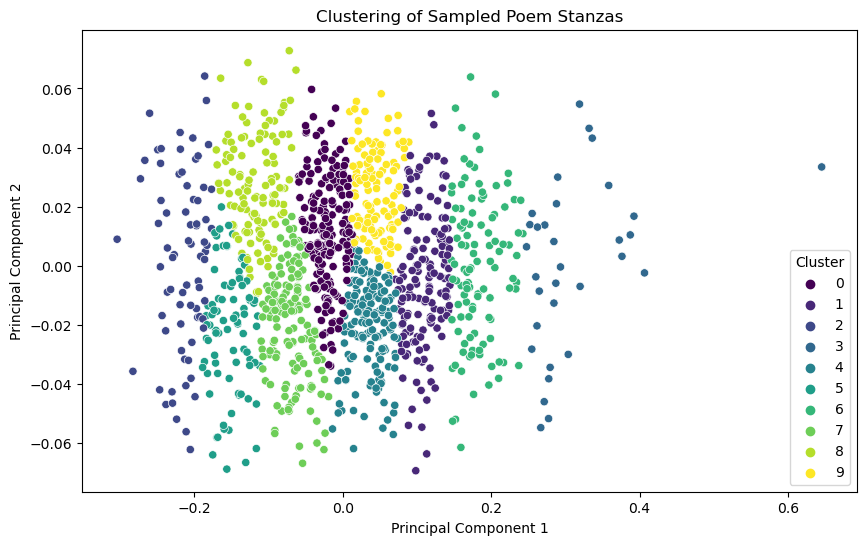

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Reduce the dimensionality of the feature space for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Create a DataFrame for visualization
viz_df = pd.DataFrame(X_reduced, columns=['PC1', 'PC2'])
viz_df['cluster'] = df['cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=viz_df, palette='viridis', legend='full')
plt.title('Clustering of Sampled Poem Stanzas')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


In [86]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(X, df['cluster'])  # X is your data

print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.26340955
